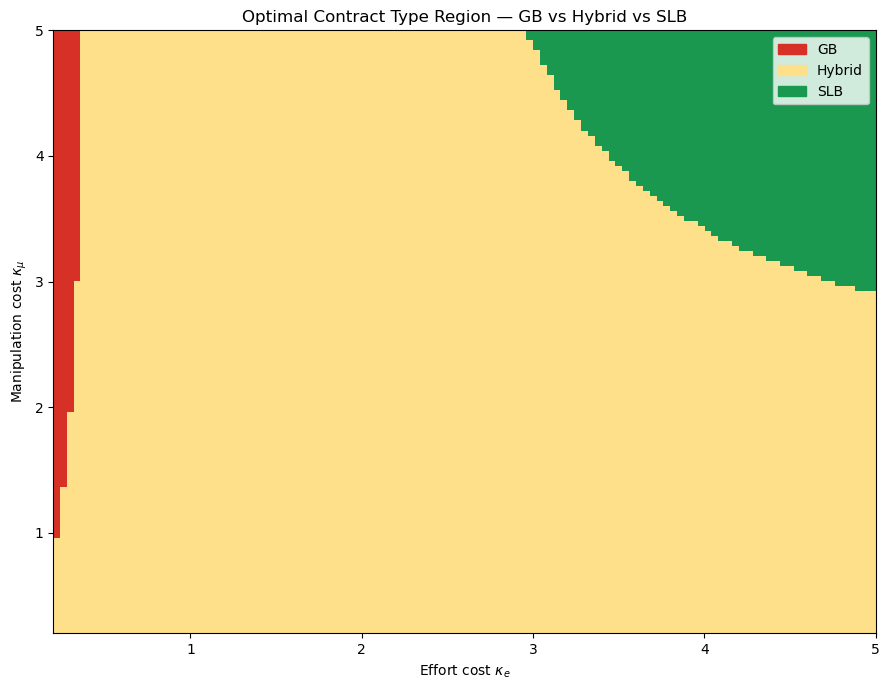

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# ============================================================
# BASELINE PARAMETER CLASS
# ============================================================

@dataclass
class BaselineParams:
    a: float = 1.0
    b: float = 1.0

    kappa_e: float = 1.0
    kappa_mu: float = 1.0
    alpha: float = 0.5

    kappa_gamma: float = 1.0

    delta: float = 0.9
    rho: float = 0.3
    theta: float = 1.1

    z1_star: float = 1.0
    z2_star: float = 1.0
    x1: int = 1
    x2: int = 1
    G1_bar: float = 1.0

    D1_bar: float = 1.0
    D2_bar: float = 1.0

    C1: float = 0.0
    C2: float = 0.0


# ============================================================
# MODEL FUNCTIONS
# ============================================================

def cost_effort(e, p):
    return 0.5 * p.kappa_e * e**2

def cost_manip(mu, p):
    return 0.5 * p.kappa_mu * p.alpha * mu**2

def cost_contract(C, p):
    return 0.5 * p.kappa_gamma * C**2

def green_signal(e, mu, p):
    return p.a * e + mu

def project_return(e, p):
    return p.b * e

def phi_t(psi, z_star):
    return (1 - psi) * z_star

def D1(e1, mu1, psi1, p):
    g1 = green_signal(e1, mu1, p)
    return p.D1_bar - phi_t(psi1, p.z1_star)*p.x1 - psi1*g1

def D2(e1, mu1, e2, mu2, psi1, psi2, p):
    g1 = green_signal(e1, mu1, p)
    g2 = green_signal(e2, mu2, p)
    return (p.D2_bar
            - phi_t(psi2, p.z2_star)*p.x2
            - psi2*g2
            - p.rho*(g1 - p.G1_bar))

def xi_term(p):
    return (p.a**2)/p.kappa_e + 1/(p.kappa_mu*p.alpha)

# ============================================================
# OPTIMAL ψ1*, ψ2* (LENDER)
# ============================================================

def lender_optimal_psi(p):
    Xi = xi_term(p)
    common = (p.a*p.b)/p.kappa_e

    psi1_star = p.theta/2 - p.delta*p.rho + (p.z1_star*p.x1 - common)/(2*Xi)
    psi2_star = p.theta/2 + (p.z2_star*p.x2 - common)/(2*Xi)

    return psi1_star, psi2_star

# ============================================================
# BORROWER BEST RESPONSE
# ============================================================

def borrower_optimal_e_mu(psi1, psi2, p):
    e2 = (p.b + p.a*psi2) / p.kappa_e
    mu2 = psi2 / (p.kappa_mu*p.alpha)

    e1 = (p.b + p.a*(psi1 + p.delta*p.rho)) / p.kappa_e
    mu1 = (psi1 + p.delta*p.rho) / (p.kappa_mu*p.alpha)

    return e1, e2, mu1, mu2

# ============================================================
# FULL UTILITY GIVEN ψ1, ψ2
# ============================================================

def utility_given_psi(psi1, psi2, p):
    e1, e2, mu1, mu2 = borrower_optimal_e_mu(psi1, psi2, p)

    g1 = green_signal(e1, mu1, p)
    g2 = green_signal(e2, mu2, p)

    D1v = D1(e1, mu1, psi1, p)
    D2v = D2(e1, mu1, e2, mu2, psi1, psi2, p)

    UL = D1v + p.delta*D2v + p.theta*(g1 + p.delta*g2)
    return UL

# ============================================================
# CONTRACT TYPES
# ============================================================

def U_GB(p):
    return utility_given_psi(0, 0, p)

def U_SLB(p):
    return utility_given_psi(1, 1, p)

def U_HYB(p):
    psi1, psi2 = lender_optimal_psi(p)

    # Only counts as hybrid if interior
    if psi1 <= 0 or psi1 >= 1 or psi2 <= 0 or psi2 >= 1:
        return -1e9  # hybrid "ikke feasible"

    return utility_given_psi(psi1, psi2, p)

# ============================================================
# CREATE REGION MAP
# ============================================================

p0 = BaselineParams()

ke_values  = np.linspace(0.2, 5.0, 120)
kmu_values = np.linspace(0.2, 5.0, 120)
KE, KMU = np.meshgrid(ke_values, kmu_values)

region = np.zeros_like(KE, dtype=int)  # 0=GB, 1=HYB, 2=SLB

for i in range(len(kmu_values)):
    for j in range(len(ke_values)):
        p = BaselineParams(**vars(p0))
        p.kappa_e = KE[i,j]
        p.kappa_mu = KMU[i,j]

        Ugb = U_GB(p)
        Uslb = U_SLB(p)
        Uhyb = U_HYB(p)

        region[i,j] = np.argmax([Ugb, Uhyb, Uslb])

# ============================================================
# PLOT
# ============================================================

cmap = ListedColormap(["#d73027", "#fee08b", "#1a9850"])  # GB, HYB, SLB
patches = [
    Patch(color="#d73027", label="GB"),
    Patch(color="#fee08b", label="Hybrid"),
    Patch(color="#1a9850", label="SLB")
]

plt.figure(figsize=(9,7))
plt.imshow(region, cmap=cmap, origin="lower",
           extent=[ke_values.min(), ke_values.max(),
                   kmu_values.min(), kmu_values.max()],
           aspect="auto")

plt.xlabel(r"Effort cost $\kappa_e$")
plt.ylabel(r"Manipulation cost $\kappa_\mu$")
plt.title("Optimal Contract Type Region — GB vs Hybrid vs SLB")

plt.legend(handles=patches, loc="upper right")
plt.tight_layout()
plt.show()


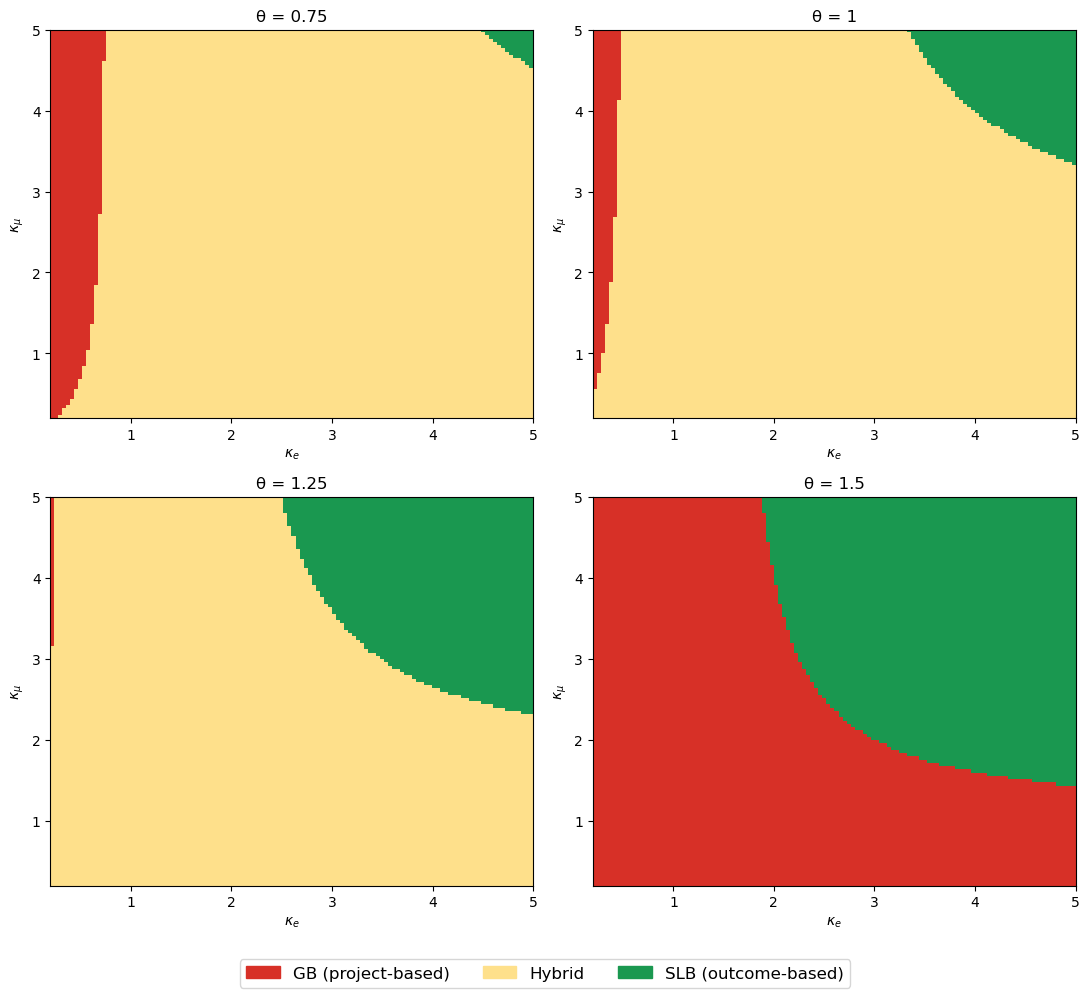

In [111]:
from matplotlib.patches import Patch

theta_slices = [0.75, 1, 1.25, 1.5]
ke_vals  = np.linspace(0.2, 5.0, 120)
kmu_vals = np.linspace(0.2, 5.0, 120)

fig, axes = plt.subplots(2,2, figsize=(11,10))

# Farverne (samme som dine)
cmap = ListedColormap(["#d73027", "#fee08b", "#1a9850"])

# Legend patches
patches = [
    Patch(color="#d73027", label="GB (project-based)"),
    Patch(color="#fee08b", label="Hybrid"),
    Patch(color="#1a9850", label="SLB (outcome-based)")
]

for idx, theta in enumerate(theta_slices):
    ax = axes[idx//2, idx%2]

    region = np.zeros((len(kmu_vals),len(ke_vals)))

    for i in range(len(kmu_vals)):
        for j in range(len(ke_vals)):
            p = BaselineParams(**vars(p0))
            p.theta = theta
            p.kappa_e = ke_vals[j]
            p.kappa_mu = kmu_vals[i]

            Ugb  = U_GB(p)
            Uslb = U_SLB(p)
            Uhyb = U_HYB(p)

            region[i,j] = np.argmax([Ugb, Uhyb, Uslb])

    im = ax.imshow(region, origin="lower",
              extent=[ke_vals.min(), ke_vals.max(),
                      kmu_vals.min(), kmu_vals.max()],
              cmap=cmap,
              aspect="auto")

    ax.set_title(f"θ = {theta}", fontsize=12)
    ax.set_xlabel(r"$\kappa_e$")
    ax.set_ylabel(r"$\kappa_\mu$")

# Tilføj legend én gang for hele figuren
fig.legend(handles=patches, loc='lower center', ncol=3, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # plads til legend nederst
plt.show()


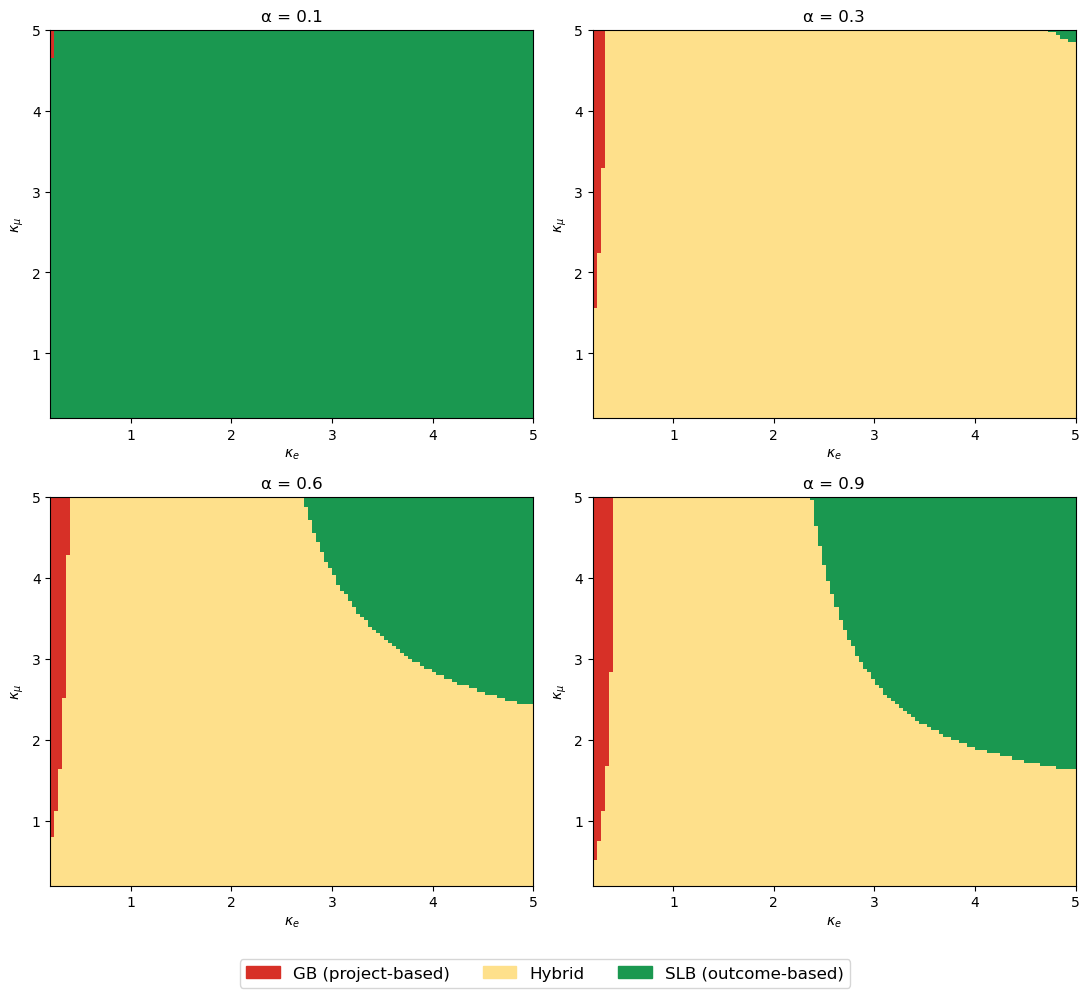

In [105]:
from matplotlib.patches import Patch

alpha_slices = [0.1, 0.3, 0.6, 0.9]
ke_vals  = np.linspace(0.2, 5.0, 120)
kmu_vals = np.linspace(0.2, 5.0, 120)

fig, axes = plt.subplots(2,2, figsize=(11,10))

# Farverne (samme som altid)
cmap = ListedColormap(["#d73027", "#fee08b", "#1a9850"])

# Legend patches
patches = [
    Patch(color="#d73027", label="GB (project-based)"),
    Patch(color="#fee08b", label="Hybrid"),
    Patch(color="#1a9850", label="SLB (outcome-based)")
]

for idx, alpha in enumerate(alpha_slices):
    ax = axes[idx//2, idx%2]

    region = np.zeros((len(kmu_vals),len(ke_vals)))

    for i in range(len(kmu_vals)):
        for j in range(len(ke_vals)):
            p = BaselineParams(**vars(p0))
            p.alpha = alpha
            p.kappa_e = ke_vals[j]
            p.kappa_mu = kmu_vals[i]

            Ugb  = U_GB(p)
            Uslb = U_SLB(p)
            Uhyb = U_HYB(p)

            region[i,j] = np.argmax([Ugb, Uhyb, Uslb])

    ax.imshow(region, origin="lower",
              extent=[ke_vals.min(), ke_vals.max(),
                      kmu_vals.min(), kmu_vals.max()],
              cmap=cmap,
              aspect="auto")

    ax.set_title(f"α = {alpha}", fontsize=12)
    ax.set_xlabel(r"$\kappa_e$")
    ax.set_ylabel(r"$\kappa_\mu$")

# fælles legend
fig.legend(handles=patches, loc='lower center', ncol=3, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()



=== Delta model ===
Discount factor      = 0.9000
psi1*                = 0.8009
psi2*                = 1.0000
e1*, mu1*            = 1.0425, 5.3545
e2*, mu2*            = 1.0000, 5.0000
D1*, D2*             = 95.0115, 92.7560
Lender utility UL    = 200.5319
Borrower utility UB  = -183.8254

=== Exogenous CAPM ===
Discount factor      = 0.9434
psi1*                = 0.7879
psi2*                = 1.0000
e1*, mu1*            = 1.0425, 5.3545
e2*, mu2*            = 1.0000, 5.0000
D1*, D2*             = 95.0764, 92.7560
Lender utility UL    = 205.1081
Borrower utility UB  = -188.0283

=== Endogenous CAPM ===
Discount factor      = 0.7794
psi1*                = 0.8371
psi2*                = 1.0000
e1*, mu1*            = 1.0425, 5.3545
e2*, mu2*            = 1.0000, 5.0000
D1*, D2*             = 94.8313, 92.7560
Lender utility UL    = 187.8102
Borrower utility UB  = -172.1412


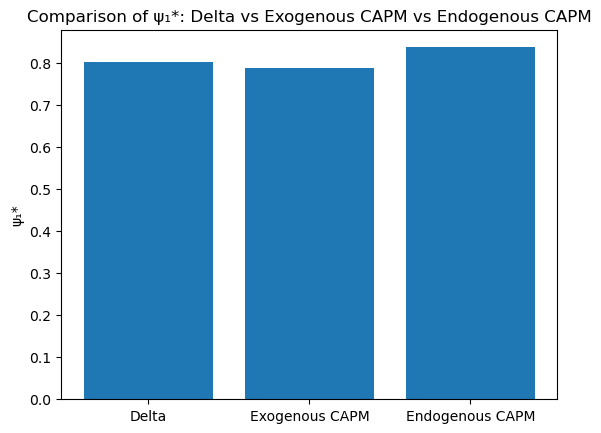

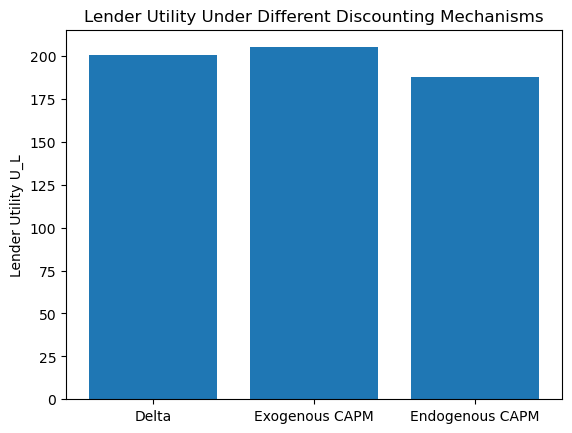

In [125]:
import numpy as np
import matplotlib.pyplot as plt

# =====================================
# PARAMETERS
# =====================================
a      = 0.6
b      = 0.4
alpha  = 0.2
delta  = 0.9
rho    = 0.3
theta  = 2.0
z      = 1.0
Gbar   = 0.5
k_e    = 1.0
k_mu   = 1.0

# Baseline face values of the debt
Dbar1  = 100.0
Dbar2  = 100.0

# CAPM parameters
r_f    = 0.02
ERM    = 0.04
beta0  = 1.0
eta_e  = 0.15
eta_mu = 0.20

# =====================================
# HELPER FUNCTIONS
# =====================================

def psi1_star(effective_delta):
    """Closed-form ψ1* projected to [0,1]."""
    num = z - (a * b) / k_e
    den = 2.0 * (a*a / k_e + 1.0 / (k_mu * alpha))
    psi = (theta / 2.0) - effective_delta * rho + num / den
    return np.clip(psi, 0, 1)

def psi2_star():
    """Closed-form ψ2* projected to [0,1]."""
    num = z - (a * b) / k_e
    den = 2.0 * (a*a / k_e + 1.0 / (k_mu * alpha))
    psi = (theta / 2.0) + num / den
    return np.clip(psi, 0, 1)

def e1_star(psi1, effective_delta):
    return (b + a * (psi1 + effective_delta * rho)) / k_e

def mu1_star(psi1, effective_delta):
    return (psi1 + effective_delta * rho) / (k_mu * alpha)

def e2_star(psi2):
    return (b + a * psi2) / k_e

def mu2_star(psi2):
    return psi2 / (k_mu * alpha)

def g1(psi1, effective_delta):
    e1 = e1_star(psi1, effective_delta)
    mu1 = mu1_star(psi1, effective_delta)
    return a * e1 + mu1

def g2(psi2):
    e2 = e2_star(psi2)
    mu2 = mu2_star(psi2)
    return a * e2 + mu2

def q2_capm(beta):
    return 1.0 / (1.0 + r_f + beta * ERM)

# =====================================
# ENDOGENOUS CAPM (FIXED POINT)
# =====================================

def solve_endogenous_capm(max_iter=500, tol=1e-10):
    """
    Solve (psi1*, q2*) under endogenous CAPM with clipping.
    """
    psi = psi1_star(delta)
    q2  = delta

    for _ in range(max_iter):
        e  = e1_star(psi, q2)
        mu = mu1_star(psi, q2)

        beta = beta0 - eta_e * e + eta_mu * (mu**2)
        q2_new = q2_capm(beta)

        psi_new = psi1_star(q2_new)

        psi_new = np.clip(psi_new, 0, 1)
        q2_new  = max(q2_new, 0)

        if abs(psi_new - psi) < tol and abs(q2_new - q2) < tol:
            psi, q2 = psi_new, q2_new
            break

        psi = 0.5 * psi + 0.5 * psi_new
        psi = np.clip(psi, 0, 1)

        q2  = 0.5 * q2  + 0.5 * q2_new
        q2  = max(q2, 0)

    e_final  = e1_star(psi, q2)
    mu_final = mu1_star(psi, q2)
    return psi, q2, e_final, mu_final

# =====================================
# UTILITY + REPAYMENT CALCULATIONS
# =====================================

def compute_equilibrium(effective_delta, psi1):
    psi2 = psi2_star()

    e1 = e1_star(psi1, effective_delta)
    mu1 = mu1_star(psi1, effective_delta)
    g_1 = a * e1 + mu1

    e2 = e2_star(psi2)
    mu2 = mu2_star(psi2)
    g_2 = a * e2 + mu2

    D1 = Dbar1 - (1.0 - psi1) * z - psi1 * g_1
    D2 = Dbar2 - (1.0 - psi2) * z - psi2 * g_2 - rho * (g_1 - Gbar)

    UL = (
        Dbar1 - (1.0 - psi1) * z
        + (theta - psi1 - effective_delta * rho) * g_1
        + effective_delta * (
            Dbar2 - (1.0 - psi2) * z - psi2 * g_2 + rho * Gbar
        )
        + theta * effective_delta * g_2
    )

    UB1 = b * e1 - D1 - 0.5 * k_e * e1**2 - 0.5 * k_mu * alpha * mu1**2
    UB2 = b * e2 - D2 - 0.5 * k_e * e2**2 - 0.5 * k_mu * alpha * mu2**2
    UB_total = UB1 + effective_delta * UB2

    return {
        "psi1": psi1,
        "psi2": psi2,
        "e1": e1,
        "mu1": mu1,
        "e2": e2,
        "mu2": mu2,
        "g1": g_1,
        "g2": g_2,
        "D1": D1,
        "D2": D2,
        "UL": UL,
        "UB": UB_total,
    }

# =====================================
# 1) DELTA MODEL
# =====================================
psi1_delta = psi1_star(delta)
res_delta = compute_equilibrium(delta, psi1_delta)

# =====================================
# 2) EXOGENOUS CAPM
# =====================================
q2_exo = q2_capm(beta0)
psi1_capm_exo = psi1_star(q2_exo)
res_capm_exo = compute_equilibrium(q2_exo, psi1_capm_exo)

# =====================================
# 3) ENDOGENOUS CAPM
# =====================================
psi1_capm_end, q2_end, e1_capm_end, mu1_capm_end = solve_endogenous_capm()
res_capm_end = compute_equilibrium(q2_end, psi1_capm_end)

# =====================================
# OUTPUT BLOCK
# =====================================
def print_block(name, res, disc):
    print(f"\n=== {name} ===")
    print(f"Discount factor      = {disc:.4f}")
    print(f"psi1*                = {res['psi1']:.4f}")
    print(f"psi2*                = {res['psi2']:.4f}")
    print(f"e1*, mu1*            = {res['e1']:.4f}, {res['mu1']:.4f}")
    print(f"e2*, mu2*            = {res['e2']:.4f}, {res['mu2']:.4f}")
    print(f"D1*, D2*             = {res['D1']:.4f}, {res['D2']:.4f}")
    print(f"Lender utility UL    = {res['UL']:.4f}")
    print(f"Borrower utility UB  = {res['UB']:.4f}")

print_block("Delta model",       res_delta,    delta)
print_block("Exogenous CAPM",    res_capm_exo, q2_exo)
print_block("Endogenous CAPM",   res_capm_end, q2_end)

# =====================================
# PLOTS
# =====================================
labels = ["Delta", "Exogenous CAPM", "Endogenous CAPM"]
psi_vals = [res_delta["psi1"], res_capm_exo["psi1"], res_capm_end["psi1"]]
UL_vals  = [res_delta["UL"],  res_capm_exo["UL"],  res_capm_end["UL"]]

plt.figure()
plt.bar(labels, psi_vals)
plt.ylabel("ψ₁*")
plt.title("Comparison of ψ₁*: Delta vs Exogenous CAPM vs Endogenous CAPM")
plt.show()

plt.figure()
plt.bar(labels, UL_vals)
plt.ylabel("Lender Utility U_L")
plt.title("Lender Utility Under Different Discounting Mechanisms")
plt.show()



=== OLD ENDOGENOUS CAPM ===
psi1* = 0.8371, q2* = 0.7794
e1* = 1.0425, mu1* = 5.3545
Lender UL = 187.8102

=== NEW ENDOGENOUS CAPM ===
psi1* = 0.7886, q2* = 0.9411
e1* = 1.0425, mu1* = 5.3545
Lender UL = 204.8630


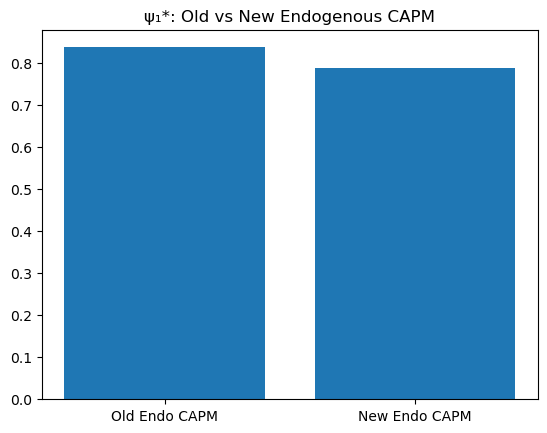

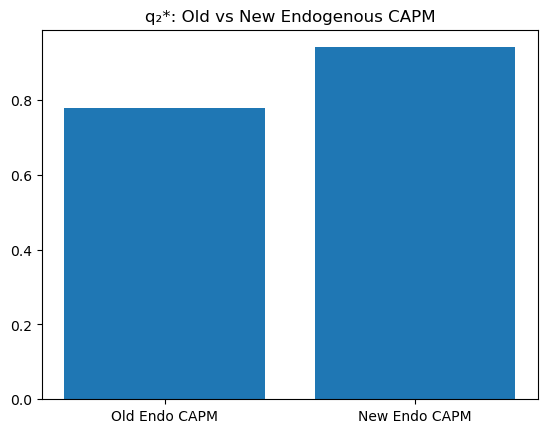

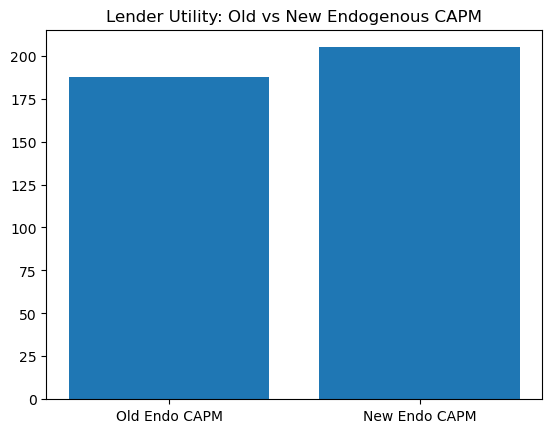

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =====================================
# PARAMETERS
# =====================================
a      = 0.6
b      = 0.4
alpha  = 0.2
delta  = 0.9
rho    = 0.3
theta  = 2.0
z      = 1.0
Gbar   = 0.5
k_e    = 1.0
k_mu   = 1.0

# Baseline debt face values
Dbar1 = 100.0
Dbar2 = 100.0

# CAPM parameters
r_f    = 0.02
ERM    = 0.04
beta0  = 1.0
eta_e  = 0.15
eta_mu = 0.20

# =====================================
# CORE FUNCTIONS (same as before)
# =====================================

def psi1_star(effective_delta):
    num = z - (a * b) / k_e
    den = 2.0 * (a*a / k_e + 1.0 / (k_mu * alpha))
    psi = (theta / 2.0) - effective_delta * rho + num / den
    return np.clip(psi, 0, 1)

def psi2_star():
    num = z - (a * b) / k_e
    den = 2.0 * (a*a / k_e + 1.0 / (k_mu * alpha))
    psi = (theta / 2.0) + num / den
    return np.clip(psi, 0, 1)

def e1_star(psi1, effective_delta):
    return (b + a * (psi1 + effective_delta * rho)) / k_e

def mu1_star(psi1, effective_delta):
    return (psi1 + effective_delta * rho) / (k_mu * alpha)

def e2_star(psi2):
    return (b + a * psi2) / k_e

def mu2_star(psi2):
    return psi2 / (k_mu * alpha)

def q2_capm(beta):
    return 1.0 / (1.0 + r_f + beta * ERM)

# =====================================
# 1. OLD ENDOGENOUS CAPM
# =====================================

def solve_endogenous_capm_old(max_iter=500, tol=1e-10):
    psi = psi1_star(delta)
    q2  = delta

    for _ in range(max_iter):
        e  = e1_star(psi, q2)
        mu = mu1_star(psi, q2)

        # OLD BETA FUNCTION
        beta = beta0 - eta_e * e + eta_mu * (mu**2)

        q2_new = q2_capm(beta)
        psi_new = psi1_star(q2_new)

        psi_new = np.clip(psi_new, 0, 1)
        q2_new  = max(q2_new, 0)

        if abs(psi_new - psi) < tol and abs(q2_new - q2) < tol:
            psi, q2 = psi_new, q2_new
            break

        psi = 0.5*psi + 0.5*psi_new
        q2  = 0.5*q2  + 0.5*q2_new

    return psi, q2, e1_star(psi,q2), mu1_star(psi,q2)

# =====================================
# 2. NEW ENDOGENOUS CAPM
# =====================================

def solve_endogenous_capm_new(max_iter=500, tol=1e-10):
    psi = psi1_star(delta)
    q2  = delta

    for _ in range(max_iter):
        e  = e1_star(psi, q2)
        mu = mu1_star(psi, q2)

        # NEW BOUNDED BETA FUNCTION
        beta = beta0 \
               - eta_e * (e / (1.0 + e)) \
               + eta_mu * (mu / (1.0 + mu))

        q2_new = q2_capm(beta)
        psi_new = psi1_star(q2_new)

        psi_new = np.clip(psi_new, 0, 1)
        q2_new  = max(q2_new, 0)

        if abs(psi_new - psi) < tol and abs(q2_new - q2) < tol:
            psi, q2 = psi_new, q2_new
            break

        psi = 0.5*psi + 0.5*psi_new
        q2  = 0.5*q2  + 0.5*q2_new

    return psi, q2, e1_star(psi,q2), mu1_star(psi,q2)

# =====================================
# UTILITY CALCULATION
# =====================================

def compute_equilibrium(effective_delta, psi1):
    psi2 = psi2_star()

    e1 = e1_star(psi1, effective_delta)
    mu1 = mu1_star(psi1, effective_delta)
    g1 = a*e1 + mu1

    e2 = e2_star(psi2)
    mu2 = mu2_star(psi2)
    g2 = a*e2 + mu2

    D1 = Dbar1 - (1-psi1)*z - psi1*g1
    D2 = Dbar2 - (1-psi2)*z - psi2*g2 - rho*(g1 - Gbar)

    UL = (
        Dbar1 - (1-psi1)*z
        + (theta - psi1 - effective_delta*rho)*g1
        + effective_delta*(Dbar2 - (1-psi2)*z - psi2*g2 + rho*Gbar)
        + theta*effective_delta*g2
    )

    UB1 = b*e1 - D1 - 0.5*k_e*e1**2 - 0.5*k_mu*alpha*mu1**2
    UB2 = b*e2 - D2 - 0.5*k_e*e2**2 - 0.5*k_mu*alpha*mu2**2
    UB = UB1 + effective_delta*UB2

    return {"psi1":psi1, "psi2":psi2, "e1":e1, "mu1":mu1,
            "UL":UL, "UB":UB}

# =====================================
# RUN THE TWO ENDOGENOUS MODELS
# =====================================

psi_old, q2_old, e_old, mu_old = solve_endogenous_capm_old()
psi_new, q2_new, e_new, mu_new = solve_endogenous_capm_new()

res_old = compute_equilibrium(q2_old, psi_old)
res_new = compute_equilibrium(q2_new, psi_new)

# =====================================
# PRINT SUMMARY
# =====================================

print("\n=== OLD ENDOGENOUS CAPM ===")
print(f"psi1* = {psi_old:.4f}, q2* = {q2_old:.4f}")
print(f"e1* = {e_old:.4f}, mu1* = {mu_old:.4f}")
print(f"Lender UL = {res_old['UL']:.4f}")

print("\n=== NEW ENDOGENOUS CAPM ===")
print(f"psi1* = {psi_new:.4f}, q2* = {q2_new:.4f}")
print(f"e1* = {e_new:.4f}, mu1* = {mu_new:.4f}")
print(f"Lender UL = {res_new['UL']:.4f}")

# =====================================
# BAR PLOTS
# =====================================

labels = ["Old Endo CAPM", "New Endo CAPM"]

psi_vals = [res_old["psi1"], res_new["psi1"]]
q2_vals  = [q2_old, q2_new]
UL_vals  = [res_old["UL"], res_new["UL"]]

plt.figure()
plt.bar(labels, psi_vals)
plt.title("ψ₁*: Old vs New Endogenous CAPM")
plt.show()

plt.figure()
plt.bar(labels, q2_vals)
plt.title("q₂*: Old vs New Endogenous CAPM")
plt.show()

plt.figure()
plt.bar(labels, UL_vals)
plt.title("Lender Utility: Old vs New Endogenous CAPM")
plt.show()
